# Face Generation

This project was completed as part of the Udacity deep learning nanodegree program. 

We'll train a Generative Adverserial network on a dataset of faces. The aim for the generator network is to generate *new* images of faces that look as realistic as possible!

### Get the Data

[CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) to train the adversarial networks.

In [1]:
import os
from glob import glob
from typing import Tuple, Callable, Dict

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from PIL import Image
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms import Compose, ToTensor, Resize, Normalize

import tests

In [2]:
data_dir = 'processed_celeba_small/celeba/'

## Data pipeline

The dataset contains over 200,000 celebrity images with annotations. Since we are going to be generating faces, we won't need the annotations. We only need the images. Note that these are color images with 3 color channels (RGB)

### Pre-process and Load the Data

Each of the CelebA images has been cropped to remove parts of the image that don't include a face, then resized down to 64x64x3 NumPy images. This *pre-processed* dataset is a smaller subset of the very large CelebA dataset and contains roughly 30,000 images.

#### The `get_transforms' function
* the function takes a tuple of size as input and should **resize the images** to the input size
* the output images should have values **ranging from -1 to 1**

In [ ]:
def get_transforms(size: Tuple[int, int]) -> Callable:
    """ Transforms to apply to the image."""
    transforms = [
        Resize(size),
        ToTensor(),
        Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ]
    
    return Compose(transforms)

#### The DatasetDirectory class

The `DatasetDirectory` class is a torch Dataset that reads from the above data directory. The `__getitem__` method should output a transformed tensor and the `__len__` method should output the number of files in our dataset.

In [ ]:
class DatasetDirectory(Dataset):
    """
    A custom dataset class that loads images from folder.
    args:
    - directory: location of the images
    - transform: transform function to apply to the images
    - extension: file format
    """
    def __init__(self, 
                 directory: str, 
                 transforms: Callable = None, 
                 extension: str = '.jpg'):
        self.directory = directory
        self.transforms = transforms
        self.image_paths = glob(os.path.join(directory, '*' + extension))
        

    def __len__(self) -> int:
        """ returns the number of items in the dataset """
        return len(self.image_paths)

    def __getitem__(self, index: int) -> torch.Tensor:
        """ load an image and apply transformation """
        img_path = self.image_paths[index]
        image = Image.open(img_path).convert("RGB")
        
        if self.transforms:
            image = self.transforms(image)
            
        return image

In [ ]:
# run this cell to verify the dataset implementation
dataset = DatasetDirectory(data_dir, get_transforms((64, 64)))
tests.check_dataset_outputs(dataset)

Congrats, your dataset implementation passed all the tests


### Visualize images from the dataset.

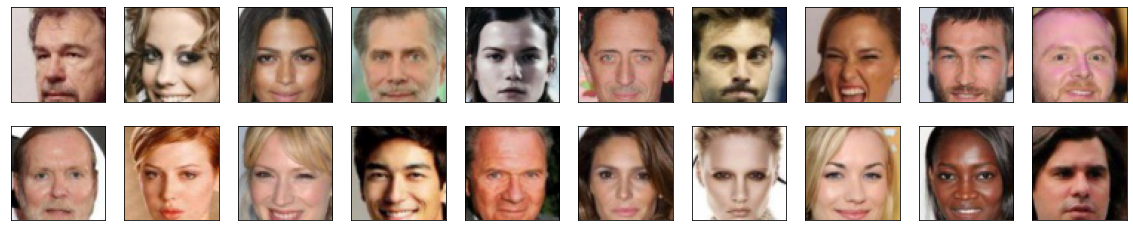

In [ ]:
def denormalize(images):
    """Transform images from [-1.0, 1.0] to [0, 255] and cast them to uint8."""
    return ((images + 1.) / 2. * 255).astype(np.uint8)

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(20, 4))
plot_size=20
for idx in np.arange(plot_size):
    ax = fig.add_subplot(2, int(plot_size/2), idx+1, xticks=[], yticks=[])
    img = dataset[idx].numpy()
    img = np.transpose(img, (1, 2, 0))
    img = denormalize(img)
    ax.imshow(img)

## Model implementation

GAN is comprised of two adversarial networks, a discriminator and a generator. Now that we have a working data pipeline, we need to implement the discriminator and the generator. 

### The discriminator

The discriminator's job is to score real and fake images:
* the discriminator takes as input a **batch of 64x64x3 images**
* the output should be a single value (=score)

In [7]:
from torch.nn import Module

In [ ]:
class Discriminator(Module):
    def __init__(self, conv_dim=64):
        super(Discriminator, self).__init__()
        self.conv_dim = conv_dim
        
        def conv(in_c, out_c, kernel=4, stride=2, pad=1, bn=True):
            layers = [nn.Conv2d(in_c, out_c, kernel, stride, pad, bias=False)]
            if bn: layers.append(nn.BatchNorm2d(out_c))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return nn.Sequential(*layers)
        
        self.main = nn.Sequential(
            conv(3, conv_dim, bn=False),           # 32x32
            conv(conv_dim, conv_dim*2),            # 16x16
            conv(conv_dim*2, conv_dim*4),          # 8x8
            conv(conv_dim*4, conv_dim*8),          # 4x4
            nn.Conv2d(conv_dim*8, 1, 4, 1, 0, bias=False) # 1x1 output
        )
            
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.main(x)

In [ ]:
# run this cell to check the discriminator implementation
discriminator = Discriminator()
tests.check_discriminator(discriminator)

Congrats, your discriminator implementation passed all the tests


### The generator

The generator's job creates the "fake images" and learns the dataset distribution.
* the generator takes as input a vector of dimension `[batch_size, latent_dimension, 1, 1]`
* the generator must outputs **64x64x3 images**

In [ ]:
class Generator(Module):
    def __init__(self, latent_dim: int, conv_dim=64):
        super(Generator, self).__init__()
        def deconv(in_c, out_c, kernel=4, stride=2, pad=1, bn=True):
            layers = [nn.ConvTranspose2d(in_c, out_c, kernel, stride, pad, bias=False)]
            if bn:
                layers.append(nn.BatchNorm2d(out_c))
                layers.append(nn.ReLU(True))
            else:
                layers.append(nn.Tanh())
            return nn.Sequential(*layers)
        
        self.main = nn.Sequential(
            deconv(latent_dim, conv_dim*8, 4, 1, 0), # 4x4
            deconv(conv_dim*8, conv_dim*4),          # 8x8
            deconv(conv_dim*4, conv_dim*2),          # 16x16
            deconv(conv_dim*2, conv_dim),            # 32x32
            deconv(conv_dim, 3, bn=False)            # 64x64
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.main(x)

In [ ]:
# run this cell to verify the generator implementation
latent_dim = 128
generator = Generator(latent_dim)
tests.check_generator(generator, latent_dim)

Congrats, your generator implementation passed all the tests


## Optimizer

The optimizers for the generator and discriminator.

In [ ]:
import torch.optim as optim

def create_optimizers(generator: Module, discriminator: Module):
    """ This function should return the optimizers of the generator and the discriminator """
    # Adam optimizer with learning rate 0.0002 and beta1 0.5 is standard for DCGAN
    lr = 0.0002
    beta1 = 0.5
    beta2 = 0.999
    
    g_optimizer = optim.Adam(generator.parameters(), lr=lr, betas=(beta1, beta2))
    d_optimizer = optim.Adam(discriminator.parameters(), lr=lr, betas=(beta1, beta2))
    return g_optimizer, d_optimizer

## Losses implementation

The loss function for the generator and the discriminator.

In [ ]:
def generator_loss(fake_logits):
    """ Generator loss, takes the fake scores as inputs. """
    criterion = nn.BCEWithLogitsLoss()
    labels = torch.ones_like(fake_logits)
    loss = criterion(fake_logits, labels)
    return loss

We want the discriminator to give high scores to real images and low scores to fake ones and the discriminator loss should reflect that.

In [ ]:
def discriminator_loss(real_logits, fake_logits):
    """ Discriminator loss, takes the fake and real logits as inputs. """
    criterion = nn.BCEWithLogitsLoss()
    
    # Using 0.9 for smoothing to prevent discriminator from becoming too confident
    real_labels = torch.ones_like(real_logits) * 0.9
    real_loss = criterion(real_logits, real_labels)
    
    # Fake images: target is 0
    fake_labels = torch.zeros_like(fake_logits)
    fake_loss = criterion(fake_logits, fake_labels)
    
    # Total loss
    loss = real_loss + fake_loss
    return loss

## Training

Training will involve alternating between training the discriminator and the generator. 

In [ ]:
def generator_step(batch_size: int, latent_dim: int) -> Dict:
    """ One training step of the generator. """
    g_optimizer.zero_grad()
    
    # 1. Generate fake images
    z = torch.randn(batch_size, latent_dim, 1, 1).to(device)
    fake_images = generator(z)
    
    # 2. Compute loss
    # We pass the fake images to discriminator
    fake_logits = discriminator(fake_images)
    g_loss = generator_loss(fake_logits)
    
    # 3. Backprop
    g_loss.backward()
    g_optimizer.step()
    
    return {'loss': g_loss}


def discriminator_step(batch_size: int, latent_dim: int, real_images: torch.Tensor) -> Dict:
    """ One training step of the discriminator. """
    d_optimizer.zero_grad()
    
    # 1. Train with real images
    real_logits = discriminator(real_images)
    
    # 2. Train with fake images
    z = torch.randn(batch_size, latent_dim, 1, 1).to(device)
    fake_images = generator(z)
    # Detach because we don't want to update generator weights here
    fake_logits = discriminator(fake_images.detach()) 
    
    # 3. Compute loss
    d_loss = discriminator_loss(real_logits, fake_logits)
    
    # 4. Backprop
    d_loss.backward()
    d_optimizer.step()
    
    gp = 0 # Placeholder to implement gradient penalty later
    
    return {'loss': d_loss, 'gp': gp}

### Main training loop

In [16]:
from datetime import datetime

In [ ]:
# dimensions of latent spaces
latent_dim = 128

# update to cpu if you do not have access to a gpu
device = 'cuda'

# number of epochs to train your model
n_epochs = 20

# number of images in each batch
batch_size = 64

In [ ]:
# interval for printing and saving images
print_every = 50

# Create optimizers for the discriminator D and generator G
generator = Generator(latent_dim).to(device)
discriminator = Discriminator().to(device)
g_optimizer, d_optimizer = create_optimizers(generator, discriminator)

dataloader = DataLoader(dataset, 
                        batch_size=64, 
                        shuffle=True, 
                        num_workers=4, 
                        drop_last=True,
                        pin_memory=False)

In [ ]:
def display(fixed_latent_vector: torch.Tensor):
    """ helper function to display images during training """
    fig = plt.figure(figsize=(14, 4))
    plot_size = 16
    for idx in np.arange(plot_size):
        ax = fig.add_subplot(2, int(plot_size/2), idx+1, xticks=[], yticks=[])
        img = fixed_latent_vector[idx, ...].detach().cpu().numpy()
        img = np.transpose(img, (1, 2, 0))
        img = denormalize(img)
        ax.imshow(img)
    plt.show()

### Implement the training strategy

In this strategy we:
* train the generator more often than the discriminator. 
* added noise to the input image
* use label smoothing

2025-12-19 02:34:35 | Epoch [1/20] | Batch 0/509 | d_loss: 1.5119 | g_loss: 2.2073
2025-12-19 02:34:41 | Epoch [1/20] | Batch 50/509 | d_loss: 0.4002 | g_loss: 10.5539
2025-12-19 02:34:46 | Epoch [1/20] | Batch 100/509 | d_loss: 0.5808 | g_loss: 3.1543
2025-12-19 02:34:53 | Epoch [1/20] | Batch 150/509 | d_loss: 0.5178 | g_loss: 4.3961
2025-12-19 02:34:59 | Epoch [1/20] | Batch 200/509 | d_loss: 1.0202 | g_loss: 4.1813
2025-12-19 02:35:05 | Epoch [1/20] | Batch 250/509 | d_loss: 0.5712 | g_loss: 4.6104
2025-12-19 02:35:10 | Epoch [1/20] | Batch 300/509 | d_loss: 0.5863 | g_loss: 2.8328
2025-12-19 02:35:16 | Epoch [1/20] | Batch 350/509 | d_loss: 0.4918 | g_loss: 3.4882
2025-12-19 02:35:21 | Epoch [1/20] | Batch 400/509 | d_loss: 0.9416 | g_loss: 6.8389
2025-12-19 02:35:27 | Epoch [1/20] | Batch 450/509 | d_loss: 1.5152 | g_loss: 6.6034
2025-12-19 02:35:33 | Epoch [1/20] | Batch 500/509 | d_loss: 1.3609 | g_loss: 1.5839


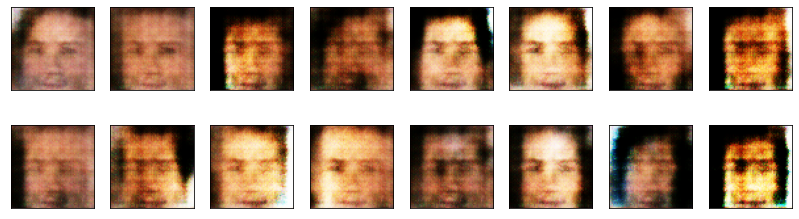

2025-12-19 02:35:35 | Epoch [2/20] | Batch 0/509 | d_loss: 0.7240 | g_loss: 2.9049
2025-12-19 02:35:40 | Epoch [2/20] | Batch 50/509 | d_loss: 0.5389 | g_loss: 4.2527
2025-12-19 02:35:46 | Epoch [2/20] | Batch 100/509 | d_loss: 0.9550 | g_loss: 8.1193
2025-12-19 02:35:51 | Epoch [2/20] | Batch 150/509 | d_loss: 0.6571 | g_loss: 3.9711
2025-12-19 02:35:57 | Epoch [2/20] | Batch 200/509 | d_loss: 1.9033 | g_loss: 11.3358
2025-12-19 02:36:02 | Epoch [2/20] | Batch 250/509 | d_loss: 0.4801 | g_loss: 3.7532
2025-12-19 02:36:08 | Epoch [2/20] | Batch 300/509 | d_loss: 0.4965 | g_loss: 4.9001
2025-12-19 02:36:14 | Epoch [2/20] | Batch 350/509 | d_loss: 0.6704 | g_loss: 3.2791
2025-12-19 02:36:19 | Epoch [2/20] | Batch 400/509 | d_loss: 2.5133 | g_loss: 12.5699
2025-12-19 02:36:25 | Epoch [2/20] | Batch 450/509 | d_loss: 0.8866 | g_loss: 4.5508
2025-12-19 02:36:31 | Epoch [2/20] | Batch 500/509 | d_loss: 0.4463 | g_loss: 5.4939


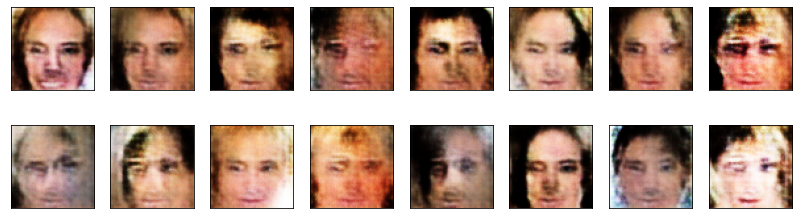

2025-12-19 02:36:33 | Epoch [3/20] | Batch 0/509 | d_loss: 0.6555 | g_loss: 2.5034
2025-12-19 02:36:39 | Epoch [3/20] | Batch 50/509 | d_loss: 0.7537 | g_loss: 3.7387
2025-12-19 02:36:44 | Epoch [3/20] | Batch 100/509 | d_loss: 0.6164 | g_loss: 5.1872
2025-12-19 02:36:50 | Epoch [3/20] | Batch 150/509 | d_loss: 0.7492 | g_loss: 2.9387
2025-12-19 02:36:55 | Epoch [3/20] | Batch 200/509 | d_loss: 0.7217 | g_loss: 3.0830
2025-12-19 02:37:01 | Epoch [3/20] | Batch 250/509 | d_loss: 0.8450 | g_loss: 2.3102
2025-12-19 02:37:07 | Epoch [3/20] | Batch 300/509 | d_loss: 0.9727 | g_loss: 2.0970
2025-12-19 02:37:12 | Epoch [3/20] | Batch 350/509 | d_loss: 2.9172 | g_loss: 5.3389
2025-12-19 02:37:18 | Epoch [3/20] | Batch 400/509 | d_loss: 0.5964 | g_loss: 3.8709
2025-12-19 02:37:23 | Epoch [3/20] | Batch 450/509 | d_loss: 0.6189 | g_loss: 4.1121
2025-12-19 02:37:29 | Epoch [3/20] | Batch 500/509 | d_loss: 0.8294 | g_loss: 4.8810


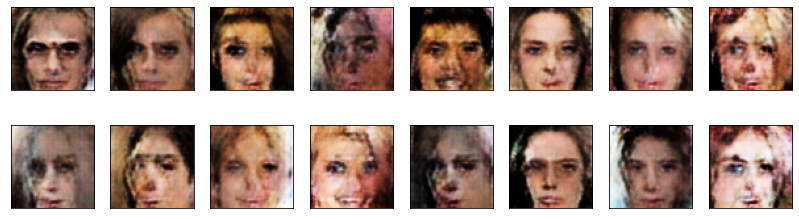

2025-12-19 02:37:31 | Epoch [4/20] | Batch 0/509 | d_loss: 0.7808 | g_loss: 4.8201
2025-12-19 02:37:37 | Epoch [4/20] | Batch 50/509 | d_loss: 0.5796 | g_loss: 3.2962
2025-12-19 02:37:42 | Epoch [4/20] | Batch 100/509 | d_loss: 0.5377 | g_loss: 2.9990
2025-12-19 02:37:48 | Epoch [4/20] | Batch 150/509 | d_loss: 0.5993 | g_loss: 3.7519
2025-12-19 02:37:54 | Epoch [4/20] | Batch 200/509 | d_loss: 0.4887 | g_loss: 3.5105
2025-12-19 02:37:59 | Epoch [4/20] | Batch 250/509 | d_loss: 1.1493 | g_loss: 6.8374
2025-12-19 02:38:05 | Epoch [4/20] | Batch 300/509 | d_loss: 0.5949 | g_loss: 3.4101
2025-12-19 02:38:11 | Epoch [4/20] | Batch 350/509 | d_loss: 0.7382 | g_loss: 1.6723
2025-12-19 02:38:16 | Epoch [4/20] | Batch 400/509 | d_loss: 1.1530 | g_loss: 4.3513
2025-12-19 02:38:22 | Epoch [4/20] | Batch 450/509 | d_loss: 0.6334 | g_loss: 4.0534
2025-12-19 02:38:27 | Epoch [4/20] | Batch 500/509 | d_loss: 1.1630 | g_loss: 6.4353


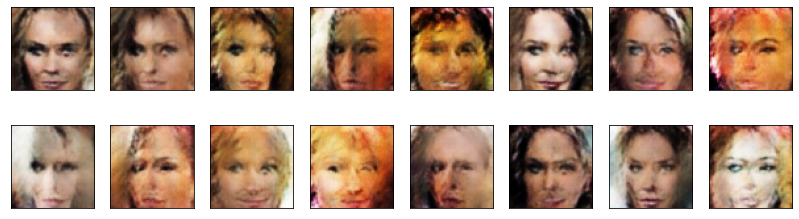

2025-12-19 02:38:30 | Epoch [5/20] | Batch 0/509 | d_loss: 0.6058 | g_loss: 2.6557
2025-12-19 02:38:35 | Epoch [5/20] | Batch 50/509 | d_loss: 0.7373 | g_loss: 3.6137
2025-12-19 02:38:41 | Epoch [5/20] | Batch 100/509 | d_loss: 0.4761 | g_loss: 5.3541
2025-12-19 02:38:47 | Epoch [5/20] | Batch 150/509 | d_loss: 0.5922 | g_loss: 3.6259
2025-12-19 02:38:52 | Epoch [5/20] | Batch 200/509 | d_loss: 0.4941 | g_loss: 3.1306
2025-12-19 02:38:58 | Epoch [5/20] | Batch 250/509 | d_loss: 0.7238 | g_loss: 3.8636
2025-12-19 02:39:03 | Epoch [5/20] | Batch 300/509 | d_loss: 0.6036 | g_loss: 3.0712
2025-12-19 02:39:09 | Epoch [5/20] | Batch 350/509 | d_loss: 0.5166 | g_loss: 4.2664
2025-12-19 02:39:15 | Epoch [5/20] | Batch 400/509 | d_loss: 0.4653 | g_loss: 4.8093
2025-12-19 02:39:20 | Epoch [5/20] | Batch 450/509 | d_loss: 1.1574 | g_loss: 4.4032
2025-12-19 02:39:26 | Epoch [5/20] | Batch 500/509 | d_loss: 0.6505 | g_loss: 2.7265


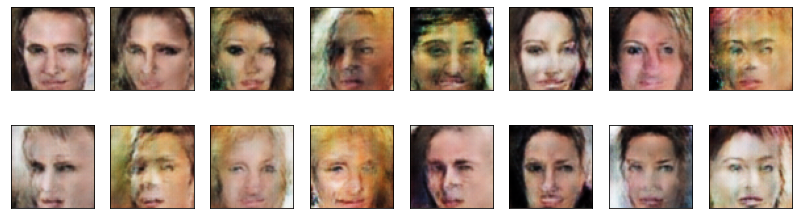

2025-12-19 02:39:28 | Epoch [6/20] | Batch 0/509 | d_loss: 0.8375 | g_loss: 5.1261
2025-12-19 02:39:34 | Epoch [6/20] | Batch 50/509 | d_loss: 1.2330 | g_loss: 6.4936
2025-12-19 02:39:39 | Epoch [6/20] | Batch 100/509 | d_loss: 0.4000 | g_loss: 4.3870
2025-12-19 02:39:45 | Epoch [6/20] | Batch 150/509 | d_loss: 0.4403 | g_loss: 3.6678
2025-12-19 02:39:51 | Epoch [6/20] | Batch 200/509 | d_loss: 0.7095 | g_loss: 3.2208
2025-12-19 02:39:56 | Epoch [6/20] | Batch 250/509 | d_loss: 0.4647 | g_loss: 4.0198
2025-12-19 02:40:02 | Epoch [6/20] | Batch 300/509 | d_loss: 0.7169 | g_loss: 4.3479
2025-12-19 02:40:07 | Epoch [6/20] | Batch 350/509 | d_loss: 0.3958 | g_loss: 4.5507
2025-12-19 02:40:13 | Epoch [6/20] | Batch 400/509 | d_loss: 0.4925 | g_loss: 4.2183
2025-12-19 02:40:19 | Epoch [6/20] | Batch 450/509 | d_loss: 0.3812 | g_loss: 4.8205
2025-12-19 02:40:24 | Epoch [6/20] | Batch 500/509 | d_loss: 1.1099 | g_loss: 2.9898


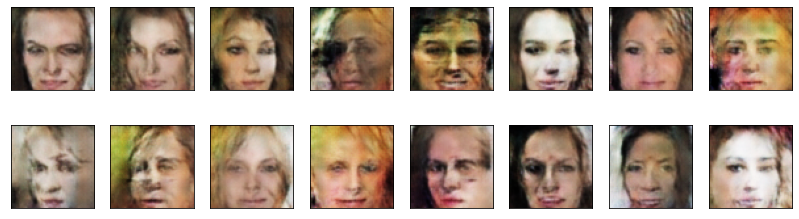

2025-12-19 02:40:27 | Epoch [7/20] | Batch 0/509 | d_loss: 0.4510 | g_loss: 3.9915
2025-12-19 02:40:32 | Epoch [7/20] | Batch 50/509 | d_loss: 0.4201 | g_loss: 3.5074
2025-12-19 02:40:38 | Epoch [7/20] | Batch 100/509 | d_loss: 0.9846 | g_loss: 1.8363
2025-12-19 02:40:43 | Epoch [7/20] | Batch 150/509 | d_loss: 0.4560 | g_loss: 2.9956
2025-12-19 02:40:49 | Epoch [7/20] | Batch 200/509 | d_loss: 0.3770 | g_loss: 5.2667
2025-12-19 02:40:55 | Epoch [7/20] | Batch 250/509 | d_loss: 0.4517 | g_loss: 3.9004
2025-12-19 02:41:00 | Epoch [7/20] | Batch 300/509 | d_loss: 0.4682 | g_loss: 3.5680
2025-12-19 02:41:06 | Epoch [7/20] | Batch 350/509 | d_loss: 0.4610 | g_loss: 3.8039
2025-12-19 02:41:12 | Epoch [7/20] | Batch 400/509 | d_loss: 0.4149 | g_loss: 3.8621
2025-12-19 02:41:17 | Epoch [7/20] | Batch 450/509 | d_loss: 0.4156 | g_loss: 4.1793
2025-12-19 02:41:23 | Epoch [7/20] | Batch 500/509 | d_loss: 1.2299 | g_loss: 4.5525


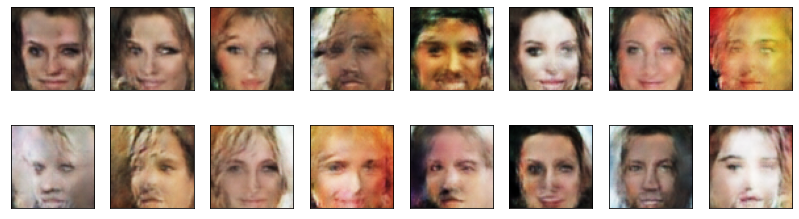

2025-12-19 02:41:25 | Epoch [8/20] | Batch 0/509 | d_loss: 0.7094 | g_loss: 4.4687
2025-12-19 02:41:31 | Epoch [8/20] | Batch 50/509 | d_loss: 0.7611 | g_loss: 5.1479
2025-12-19 02:41:36 | Epoch [8/20] | Batch 100/509 | d_loss: 0.4977 | g_loss: 3.2555
2025-12-19 02:41:42 | Epoch [8/20] | Batch 150/509 | d_loss: 0.4580 | g_loss: 3.5031
2025-12-19 02:41:47 | Epoch [8/20] | Batch 200/509 | d_loss: 0.4377 | g_loss: 3.4694
2025-12-19 02:41:53 | Epoch [8/20] | Batch 250/509 | d_loss: 0.5788 | g_loss: 2.6933
2025-12-19 02:41:59 | Epoch [8/20] | Batch 300/509 | d_loss: 0.4207 | g_loss: 4.3516
2025-12-19 02:42:04 | Epoch [8/20] | Batch 350/509 | d_loss: 2.1282 | g_loss: 9.6212
2025-12-19 02:42:10 | Epoch [8/20] | Batch 400/509 | d_loss: 0.4578 | g_loss: 6.1108
2025-12-19 02:42:15 | Epoch [8/20] | Batch 450/509 | d_loss: 0.5034 | g_loss: 3.7449
2025-12-19 02:42:21 | Epoch [8/20] | Batch 500/509 | d_loss: 0.3875 | g_loss: 5.1866


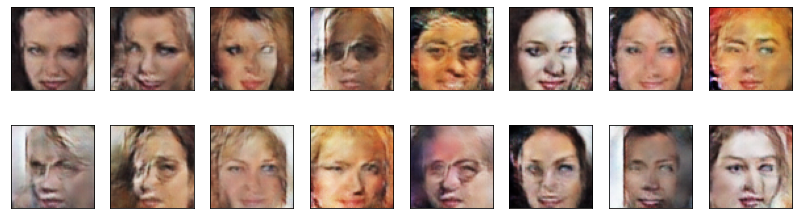

2025-12-19 02:42:24 | Epoch [9/20] | Batch 0/509 | d_loss: 0.3737 | g_loss: 4.4530
2025-12-19 02:42:29 | Epoch [9/20] | Batch 50/509 | d_loss: 0.3954 | g_loss: 5.8563
2025-12-19 02:42:35 | Epoch [9/20] | Batch 100/509 | d_loss: 0.3547 | g_loss: 5.2383
2025-12-19 02:42:40 | Epoch [9/20] | Batch 150/509 | d_loss: 0.5112 | g_loss: 3.0569
2025-12-19 02:42:46 | Epoch [9/20] | Batch 200/509 | d_loss: 0.4078 | g_loss: 3.7433
2025-12-19 02:42:51 | Epoch [9/20] | Batch 250/509 | d_loss: 0.4021 | g_loss: 4.0650
2025-12-19 02:42:57 | Epoch [9/20] | Batch 300/509 | d_loss: 0.3724 | g_loss: 3.8023
2025-12-19 02:43:03 | Epoch [9/20] | Batch 350/509 | d_loss: 0.3557 | g_loss: 4.9861
2025-12-19 02:43:08 | Epoch [9/20] | Batch 400/509 | d_loss: 0.5662 | g_loss: 4.1070
2025-12-19 02:43:14 | Epoch [9/20] | Batch 450/509 | d_loss: 0.3926 | g_loss: 4.0273
2025-12-19 02:43:19 | Epoch [9/20] | Batch 500/509 | d_loss: 0.7654 | g_loss: 6.8004


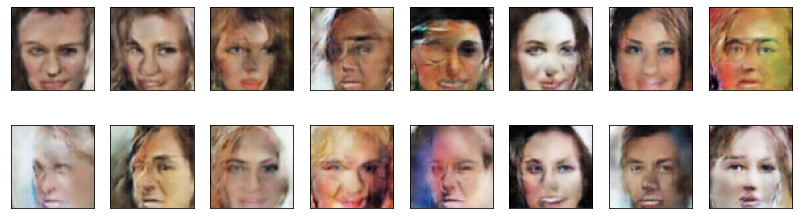

2025-12-19 02:43:22 | Epoch [10/20] | Batch 0/509 | d_loss: 0.5647 | g_loss: 4.5032
2025-12-19 02:43:27 | Epoch [10/20] | Batch 50/509 | d_loss: 0.5231 | g_loss: 3.6153
2025-12-19 02:43:33 | Epoch [10/20] | Batch 100/509 | d_loss: 0.4009 | g_loss: 4.7318
2025-12-19 02:43:39 | Epoch [10/20] | Batch 150/509 | d_loss: 0.4006 | g_loss: 5.7730
2025-12-19 02:43:44 | Epoch [10/20] | Batch 200/509 | d_loss: 0.4353 | g_loss: 3.4999
2025-12-19 02:43:50 | Epoch [10/20] | Batch 250/509 | d_loss: 0.5036 | g_loss: 3.6179
2025-12-19 02:43:55 | Epoch [10/20] | Batch 300/509 | d_loss: 0.3910 | g_loss: 3.8983
2025-12-19 02:44:01 | Epoch [10/20] | Batch 350/509 | d_loss: 0.3696 | g_loss: 5.9518
2025-12-19 02:44:06 | Epoch [10/20] | Batch 400/509 | d_loss: 0.4413 | g_loss: 6.1137
2025-12-19 02:44:12 | Epoch [10/20] | Batch 450/509 | d_loss: 0.5301 | g_loss: 3.8758
2025-12-19 02:44:17 | Epoch [10/20] | Batch 500/509 | d_loss: 1.0896 | g_loss: 3.5821


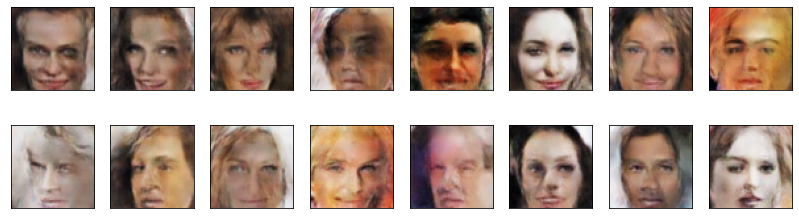

2025-12-19 02:44:20 | Epoch [11/20] | Batch 0/509 | d_loss: 0.5040 | g_loss: 3.9419
2025-12-19 02:44:26 | Epoch [11/20] | Batch 50/509 | d_loss: 0.3510 | g_loss: 7.3505
2025-12-19 02:44:31 | Epoch [11/20] | Batch 100/509 | d_loss: 0.3535 | g_loss: 5.8819
2025-12-19 02:44:37 | Epoch [11/20] | Batch 150/509 | d_loss: 0.4463 | g_loss: 4.7474
2025-12-19 02:44:42 | Epoch [11/20] | Batch 200/509 | d_loss: 0.5168 | g_loss: 4.9245
2025-12-19 02:44:48 | Epoch [11/20] | Batch 250/509 | d_loss: 0.6475 | g_loss: 2.8417
2025-12-19 02:44:53 | Epoch [11/20] | Batch 300/509 | d_loss: 0.4258 | g_loss: 4.2829
2025-12-19 02:44:59 | Epoch [11/20] | Batch 350/509 | d_loss: 0.3735 | g_loss: 3.9242
2025-12-19 02:45:05 | Epoch [11/20] | Batch 400/509 | d_loss: 0.5190 | g_loss: 3.6743
2025-12-19 02:45:10 | Epoch [11/20] | Batch 450/509 | d_loss: 0.3599 | g_loss: 6.0314
2025-12-19 02:45:16 | Epoch [11/20] | Batch 500/509 | d_loss: 0.4176 | g_loss: 3.9804


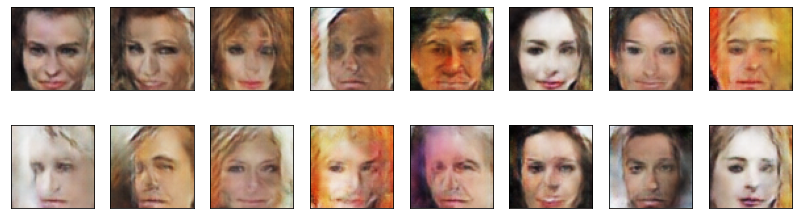

2025-12-19 02:45:18 | Epoch [12/20] | Batch 0/509 | d_loss: 0.3548 | g_loss: 8.1422
2025-12-19 02:45:24 | Epoch [12/20] | Batch 50/509 | d_loss: 0.3575 | g_loss: 5.2634
2025-12-19 02:45:29 | Epoch [12/20] | Batch 100/509 | d_loss: 0.4368 | g_loss: 4.8176
2025-12-19 02:45:35 | Epoch [12/20] | Batch 150/509 | d_loss: 0.4261 | g_loss: 3.4676
2025-12-19 02:45:41 | Epoch [12/20] | Batch 200/509 | d_loss: 0.4059 | g_loss: 5.1250
2025-12-19 02:45:46 | Epoch [12/20] | Batch 250/509 | d_loss: 0.5182 | g_loss: 4.8774
2025-12-19 02:45:52 | Epoch [12/20] | Batch 300/509 | d_loss: 0.4588 | g_loss: 3.4776
2025-12-19 02:45:57 | Epoch [12/20] | Batch 350/509 | d_loss: 0.6088 | g_loss: 5.0088
2025-12-19 02:46:03 | Epoch [12/20] | Batch 400/509 | d_loss: 0.4295 | g_loss: 4.5933
2025-12-19 02:46:08 | Epoch [12/20] | Batch 450/509 | d_loss: 0.5026 | g_loss: 3.8424
2025-12-19 02:46:14 | Epoch [12/20] | Batch 500/509 | d_loss: 0.4232 | g_loss: 3.6130


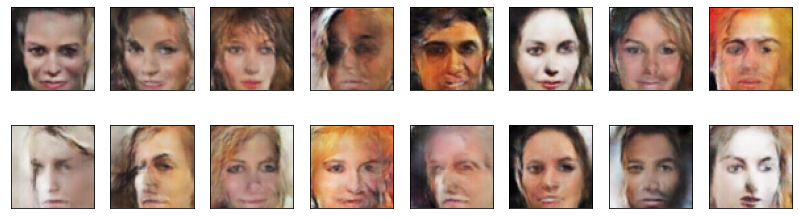

2025-12-19 02:46:16 | Epoch [13/20] | Batch 0/509 | d_loss: 0.3560 | g_loss: 4.9171
2025-12-19 02:46:22 | Epoch [13/20] | Batch 50/509 | d_loss: 0.3703 | g_loss: 4.5482
2025-12-19 02:46:27 | Epoch [13/20] | Batch 100/509 | d_loss: 0.3608 | g_loss: 4.5856
2025-12-19 02:46:33 | Epoch [13/20] | Batch 150/509 | d_loss: 0.4888 | g_loss: 2.9626
2025-12-19 02:46:39 | Epoch [13/20] | Batch 200/509 | d_loss: 0.4678 | g_loss: 4.1534
2025-12-19 02:46:44 | Epoch [13/20] | Batch 250/509 | d_loss: 0.3922 | g_loss: 4.2022
2025-12-19 02:46:50 | Epoch [13/20] | Batch 300/509 | d_loss: 0.4478 | g_loss: 4.1392
2025-12-19 02:46:55 | Epoch [13/20] | Batch 350/509 | d_loss: 0.4315 | g_loss: 4.1070
2025-12-19 02:47:01 | Epoch [13/20] | Batch 400/509 | d_loss: 0.5798 | g_loss: 5.5084
2025-12-19 02:47:07 | Epoch [13/20] | Batch 450/509 | d_loss: 0.3601 | g_loss: 5.4029
2025-12-19 02:47:12 | Epoch [13/20] | Batch 500/509 | d_loss: 0.3929 | g_loss: 4.6477


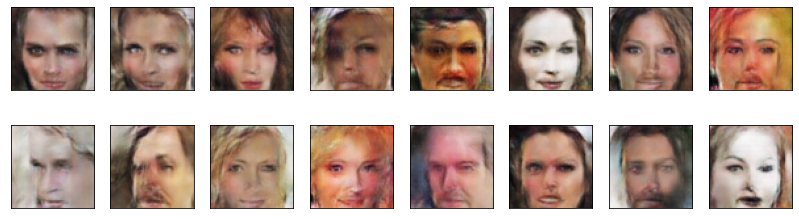

2025-12-19 02:47:15 | Epoch [14/20] | Batch 0/509 | d_loss: 0.4372 | g_loss: 5.0362
2025-12-19 02:47:20 | Epoch [14/20] | Batch 50/509 | d_loss: 0.3519 | g_loss: 5.1987
2025-12-19 02:47:26 | Epoch [14/20] | Batch 100/509 | d_loss: 0.3882 | g_loss: 3.8990
2025-12-19 02:47:31 | Epoch [14/20] | Batch 150/509 | d_loss: 0.4415 | g_loss: 4.7463
2025-12-19 02:47:37 | Epoch [14/20] | Batch 200/509 | d_loss: 0.4195 | g_loss: 4.4576
2025-12-19 02:47:43 | Epoch [14/20] | Batch 250/509 | d_loss: 0.4629 | g_loss: 4.7749
2025-12-19 02:47:48 | Epoch [14/20] | Batch 300/509 | d_loss: 0.3627 | g_loss: 5.0730
2025-12-19 02:47:54 | Epoch [14/20] | Batch 350/509 | d_loss: 0.3784 | g_loss: 7.1644
2025-12-19 02:47:59 | Epoch [14/20] | Batch 400/509 | d_loss: 0.3617 | g_loss: 5.6530
2025-12-19 02:48:05 | Epoch [14/20] | Batch 450/509 | d_loss: 0.5285 | g_loss: 5.4840
2025-12-19 02:48:10 | Epoch [14/20] | Batch 500/509 | d_loss: 0.4754 | g_loss: 4.2922


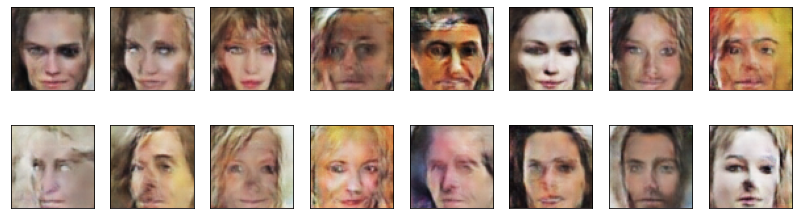

2025-12-19 02:48:13 | Epoch [15/20] | Batch 0/509 | d_loss: 0.3935 | g_loss: 4.0599
2025-12-19 02:48:18 | Epoch [15/20] | Batch 50/509 | d_loss: 0.3829 | g_loss: 5.4709
2025-12-19 02:48:24 | Epoch [15/20] | Batch 100/509 | d_loss: 0.3691 | g_loss: 4.9270
2025-12-19 02:48:29 | Epoch [15/20] | Batch 150/509 | d_loss: 0.4794 | g_loss: 4.0915
2025-12-19 02:48:35 | Epoch [15/20] | Batch 200/509 | d_loss: 0.5101 | g_loss: 4.4573
2025-12-19 02:48:41 | Epoch [15/20] | Batch 250/509 | d_loss: 0.4457 | g_loss: 4.7410
2025-12-19 02:48:46 | Epoch [15/20] | Batch 300/509 | d_loss: 0.5024 | g_loss: 5.7139
2025-12-19 02:48:52 | Epoch [15/20] | Batch 350/509 | d_loss: 0.4278 | g_loss: 4.4480
2025-12-19 02:48:57 | Epoch [15/20] | Batch 400/509 | d_loss: 0.3743 | g_loss: 4.8810
2025-12-19 02:49:03 | Epoch [15/20] | Batch 450/509 | d_loss: 0.4472 | g_loss: 5.2221
2025-12-19 02:49:09 | Epoch [15/20] | Batch 500/509 | d_loss: 0.4337 | g_loss: 6.6742


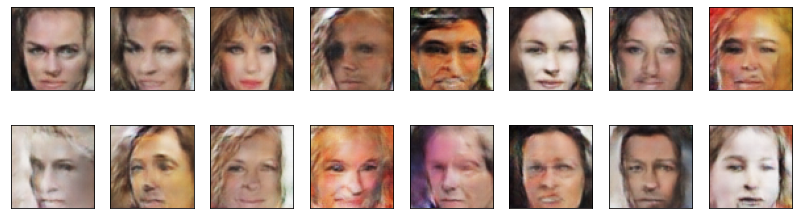

2025-12-19 02:49:11 | Epoch [16/20] | Batch 0/509 | d_loss: 0.3871 | g_loss: 4.5300
2025-12-19 02:49:17 | Epoch [16/20] | Batch 50/509 | d_loss: 0.5146 | g_loss: 2.7134
2025-12-19 02:49:22 | Epoch [16/20] | Batch 100/509 | d_loss: 0.3623 | g_loss: 5.0588
2025-12-19 02:49:28 | Epoch [16/20] | Batch 150/509 | d_loss: 0.3986 | g_loss: 4.7176
2025-12-19 02:49:33 | Epoch [16/20] | Batch 200/509 | d_loss: 0.5179 | g_loss: 3.0832
2025-12-19 02:49:39 | Epoch [16/20] | Batch 250/509 | d_loss: 0.4573 | g_loss: 3.3665
2025-12-19 02:49:45 | Epoch [16/20] | Batch 300/509 | d_loss: 0.4213 | g_loss: 4.0843
2025-12-19 02:49:50 | Epoch [16/20] | Batch 350/509 | d_loss: 0.4319 | g_loss: 3.7763
2025-12-19 02:49:56 | Epoch [16/20] | Batch 400/509 | d_loss: 0.4480 | g_loss: 5.4641
2025-12-19 02:50:01 | Epoch [16/20] | Batch 450/509 | d_loss: 0.4579 | g_loss: 5.6828
2025-12-19 02:50:07 | Epoch [16/20] | Batch 500/509 | d_loss: 0.4863 | g_loss: 4.8863


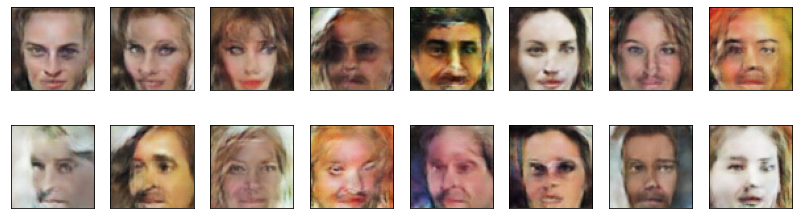

2025-12-19 02:50:09 | Epoch [17/20] | Batch 0/509 | d_loss: 0.4904 | g_loss: 5.0956
2025-12-19 02:50:15 | Epoch [17/20] | Batch 50/509 | d_loss: 0.6354 | g_loss: 4.8622
2025-12-19 02:50:20 | Epoch [17/20] | Batch 100/509 | d_loss: 0.3881 | g_loss: 6.3149
2025-12-19 02:50:26 | Epoch [17/20] | Batch 150/509 | d_loss: 1.1615 | g_loss: 0.5977
2025-12-19 02:50:32 | Epoch [17/20] | Batch 200/509 | d_loss: 0.4013 | g_loss: 6.0376
2025-12-19 02:50:37 | Epoch [17/20] | Batch 250/509 | d_loss: 0.4149 | g_loss: 3.6714
2025-12-19 02:50:43 | Epoch [17/20] | Batch 300/509 | d_loss: 0.3693 | g_loss: 5.5301
2025-12-19 02:50:48 | Epoch [17/20] | Batch 350/509 | d_loss: 0.4292 | g_loss: 3.2238
2025-12-19 02:50:54 | Epoch [17/20] | Batch 400/509 | d_loss: 0.3917 | g_loss: 4.4444
2025-12-19 02:51:00 | Epoch [17/20] | Batch 450/509 | d_loss: 0.4668 | g_loss: 3.3609
2025-12-19 02:51:05 | Epoch [17/20] | Batch 500/509 | d_loss: 0.3622 | g_loss: 5.8483


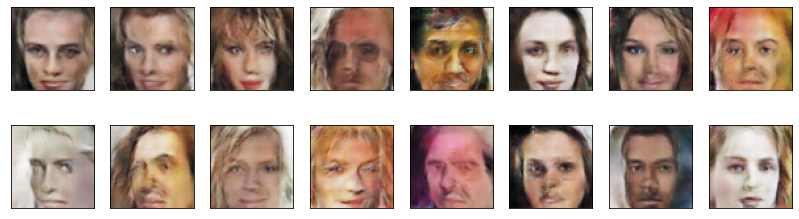

2025-12-19 02:51:08 | Epoch [18/20] | Batch 0/509 | d_loss: 0.3905 | g_loss: 4.5670
2025-12-19 02:51:13 | Epoch [18/20] | Batch 50/509 | d_loss: 0.3649 | g_loss: 5.0847
2025-12-19 02:51:19 | Epoch [18/20] | Batch 100/509 | d_loss: 0.4309 | g_loss: 4.6213
2025-12-19 02:51:24 | Epoch [18/20] | Batch 150/509 | d_loss: 0.4443 | g_loss: 3.8332
2025-12-19 02:51:30 | Epoch [18/20] | Batch 200/509 | d_loss: 0.3783 | g_loss: 8.6234
2025-12-19 02:51:36 | Epoch [18/20] | Batch 250/509 | d_loss: 0.4062 | g_loss: 4.8291
2025-12-19 02:51:41 | Epoch [18/20] | Batch 300/509 | d_loss: 0.3567 | g_loss: 5.4381
2025-12-19 02:51:47 | Epoch [18/20] | Batch 350/509 | d_loss: 0.3490 | g_loss: 6.6158
2025-12-19 02:51:52 | Epoch [18/20] | Batch 400/509 | d_loss: 0.3487 | g_loss: 6.4882
2025-12-19 02:51:58 | Epoch [18/20] | Batch 450/509 | d_loss: 0.3898 | g_loss: 4.1886
2025-12-19 02:52:04 | Epoch [18/20] | Batch 500/509 | d_loss: 0.4022 | g_loss: 7.1261


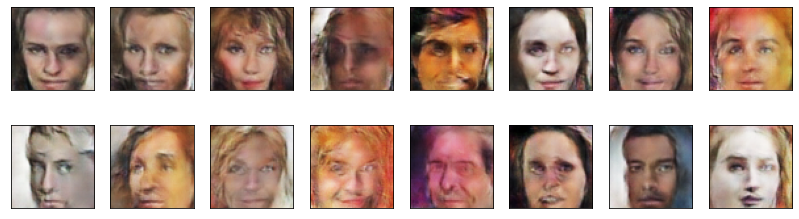

2025-12-19 02:52:06 | Epoch [19/20] | Batch 0/509 | d_loss: 0.3778 | g_loss: 4.6177
2025-12-19 02:52:11 | Epoch [19/20] | Batch 50/509 | d_loss: 0.3862 | g_loss: 4.1738
2025-12-19 02:52:17 | Epoch [19/20] | Batch 100/509 | d_loss: 0.3777 | g_loss: 5.7549
2025-12-19 02:52:23 | Epoch [19/20] | Batch 150/509 | d_loss: 0.5202 | g_loss: 1.7876
2025-12-19 02:52:28 | Epoch [19/20] | Batch 200/509 | d_loss: 0.3545 | g_loss: 4.8346
2025-12-19 02:52:34 | Epoch [19/20] | Batch 250/509 | d_loss: 0.3789 | g_loss: 4.6140
2025-12-19 02:52:39 | Epoch [19/20] | Batch 300/509 | d_loss: 0.3921 | g_loss: 4.2174
2025-12-19 02:52:45 | Epoch [19/20] | Batch 350/509 | d_loss: 0.3789 | g_loss: 7.3552
2025-12-19 02:52:51 | Epoch [19/20] | Batch 400/509 | d_loss: 0.3865 | g_loss: 5.9957
2025-12-19 02:52:56 | Epoch [19/20] | Batch 450/509 | d_loss: 0.5573 | g_loss: 3.6010
2025-12-19 02:53:02 | Epoch [19/20] | Batch 500/509 | d_loss: 0.6612 | g_loss: 4.7400


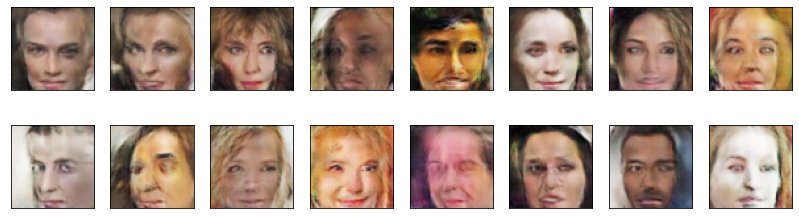

2025-12-19 02:53:04 | Epoch [20/20] | Batch 0/509 | d_loss: 0.5673 | g_loss: 4.7375
2025-12-19 02:53:10 | Epoch [20/20] | Batch 50/509 | d_loss: 0.3723 | g_loss: 5.0576
2025-12-19 02:53:15 | Epoch [20/20] | Batch 100/509 | d_loss: 0.3738 | g_loss: 4.8046
2025-12-19 02:53:21 | Epoch [20/20] | Batch 150/509 | d_loss: 0.3604 | g_loss: 4.8799
2025-12-19 02:53:27 | Epoch [20/20] | Batch 200/509 | d_loss: 0.3479 | g_loss: 6.3395
2025-12-19 02:53:32 | Epoch [20/20] | Batch 250/509 | d_loss: 0.4224 | g_loss: 3.9114
2025-12-19 02:53:38 | Epoch [20/20] | Batch 300/509 | d_loss: 0.4251 | g_loss: 4.5367
2025-12-19 02:53:43 | Epoch [20/20] | Batch 350/509 | d_loss: 0.4816 | g_loss: 5.8341
2025-12-19 02:53:49 | Epoch [20/20] | Batch 400/509 | d_loss: 0.4609 | g_loss: 5.7188
2025-12-19 02:53:54 | Epoch [20/20] | Batch 450/509 | d_loss: 0.3571 | g_loss: 7.1952
2025-12-19 02:54:00 | Epoch [20/20] | Batch 500/509 | d_loss: 0.3999 | g_loss: 5.4584


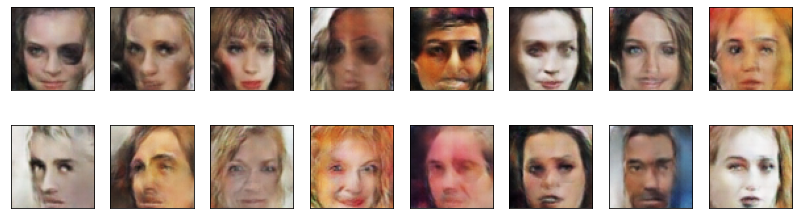

In [ ]:
fixed_latent_vector = torch.randn(16, latent_dim, 1, 1).float().cuda()

losses = []
for epoch in range(n_epochs):
    for batch_i, real_images in enumerate(dataloader):
        real_images = real_images.to(device)
        
        ####################################

        # 1. Train Discriminator
        d_loss = discriminator_step(batch_size, latent_dim, real_images)
        
        # 2. Train Generator
        g_loss = generator_step(batch_size, latent_dim)
        
        ####################################
        
        if batch_i % print_every == 0:
            # append discriminator loss and generator loss
            d = d_loss['loss'].item()
            g = g_loss['loss'].item()
            losses.append((d, g))
            # print discriminator and generator loss
            time = str(datetime.now()).split('.')[0]
            print(f'{time} | Epoch [{epoch+1}/{n_epochs}] | Batch {batch_i}/{len(dataloader)} | d_loss: {d:.4f} | g_loss: {g:.4f}')
    
    # display images during training
    generator.eval()
    generated_images = generator(fixed_latent_vector)
    display(generated_images)
    generator.train()

### Training losses

Plot the training losses for the generator and discriminator.

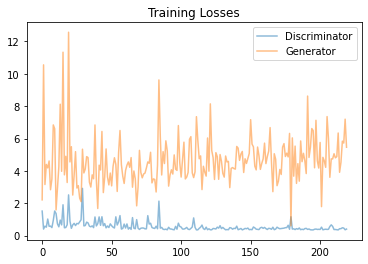

In [ ]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator', alpha=0.5)
plt.plot(losses.T[1], label='Generator', alpha=0.5)
plt.title("Training Losses")
plt.legend()

### Reflecting on generated samples and how might one improve this model


- The DCGAN architecture produces recognizable faces, though resolution is limited to 64x64 it struggles to capture very fine details like hair texture or iris patterns. To improve, one could train for more epochs (e.g., 50-100) would likely improve the results further, as GANs often require long training times to converge to a high-quality equilibrium. Although using ProGAN for higher resolution and a more diverse dataset would help improve the most. Also, using BCE loss is standard and seems to lead to vanishing gradients. Using WGAN-GP will produce better stability and image quality by preventing mode collapse and providing a more meaningful loss metric.
